In this notebook, we prove that LSTM fail into capturing long memory in multivariate time series.

Then, we applied the two complementary tests detailed in the paper *A Statistical Investigation of Long Memory in Language and Music* by Greaves-Tunnell, Alexander and Harchaoui, Zaid.

The two tests consists into checking the GSE statistics of the long memory vector d in the last hidden layer of the trained LSTM.

The difference between the two tests: the first test consists into training the LSTM on a Fractionnaly differenced WN while the second test consists into training the LSTM on a WN

In [1]:
#Google collab setting
import os
import sys
sys.path.append("LSTM-long-memory/Test Kelly")
os.chdir("LSTM-long-memory/Test Kelly")

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from _varfima import sim_VARFIMA, sim_FD
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42) #For reproductibility
from d_test import compute_total_memory

##  Building of a LSTM with two layers for multivariate time series prediction

In [3]:
#Let's build the LSTM model for time series prediction

class LSTMPredictor(nn.Module):
    """LSTM for time series prediction"""

    def __init__(self, input_size, hidden_size=64, num_layers=2,
                 dropout=0.2, forecast_horizon=1):
        """
        Args:
            input_size: Number of features (k variables)
            hidden_size: Size of the hidden state
            num_layers: Number of layers in the LSTM
            dropout: Dropout rate between LSTM layers
            forecast_horizon: Number of time steps to predict
        """
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon

        # Couche LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True  # (batch, seq, feature)
        )

        # Couche fully connected pour la prédiction
        self.fc = nn.Linear(hidden_size, input_size * forecast_horizon)

        self.input_size = input_size

    def forward(self, x):
        """
        Args:
            x: (batch, seq_length, input_size)
        Returns:
            predictions: (batch, forecast_horizon, input_size)
        """
        batch_size = x.size(0)

        # LSTM forward
        # lstm_out: (batch, seq_length, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Prendre la dernière sortie temporelle
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Prédiction
        predictions = self.fc(last_output)  # (batch, input_size*forecast_horizon)

        # Reshape pour séparer forecast_horizon et input_size
        predictions = predictions.view(batch_size, self.forecast_horizon,
                                      self.input_size)

        return predictions

k=200

## Test 1: Integration of Fractionnaly Differenced WN

##### Generation of a random Fractionally Differenced White Noise

In [4]:
# First let's generate a random long memory paramater vector (d)
np.random.seed(42)
k= 200 #number of time series
d_min, d_max = 0.05, 0.45  # to have a long memory vector parameter (d in ]0,0.5[**p)
d = torch.tensor(np.random.uniform(d_min, d_max, size=k), dtype=torch.float32)

#Then let's generated a fractionnally differenced white noise based on the generated d vector, of length T
T=2**16 #same length as in the paper, and same number k of time series
FD_seq, _ = sim_FD(T=2**16, k=200, d=d)

##### Data preparation

In [5]:
FD_seq.shape #we have a non supervised dataset of shape (k,T)

torch.Size([200, 65536])

In [6]:
# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def unfold_sequence_to_supervised_dataset(data, seq_length, forecast_horizon=1, device='cpu'):
    """
    Create a supervised dataset from multivariate time series sequence.
    with a rolling window approach.
    Args:
        data: torch.Tensor of shape (k, T)
        seq_length: length of the input window (size of X)
        forecast_horizon: number of steps to predict (size of y)

    Returns:
        X: (n_samples, seq_length, k)
        y: (n_samples, forecast_horizon, k)
    """
    data = data.to(device).T  # (T, k) on specified device
    T, k = data.shape

    n_samples = T - seq_length - forecast_horizon + 1

    X = torch.zeros((n_samples, seq_length, k), device=device)
    y = torch.zeros((n_samples, forecast_horizon, k), device=device)

    for idx in range(n_samples):
        X[idx] = data[idx:idx+seq_length]
        y[idx] = data[idx+seq_length:idx+seq_length+forecast_horizon]

    return X.float(), y.float()

Using device: cuda


We transform our generated time serie into a supervised learning dataset thanks to a rolling window of length 256, so the long memory can be visible

In [7]:
dataset = unfold_sequence_to_supervised_dataset(FD_seq, seq_length=256, forecast_horizon=1, device=device)

print(f"\nTest 1 dataset created on {device}")
print(f"  y memory: {dataset[1].element_size() * dataset[1].nelement() / 1e9:.2f} GB")
print(f"  X memory: {dataset[0].element_size() * dataset[0].nelement() / 1e9:.2f} GB")


Test 1 dataset created on cuda
  y memory: 0.05 GB
  X memory: 13.37 GB


In [8]:
print(f"Size of X: {dataset[0].shape} \nSize of y: {dataset[1].shape}")

Size of X: torch.Size([65280, 256, 200]) 
Size of y: torch.Size([65280, 1, 200])


In [9]:
#Let's prepare the dataset of training and validation

#tensorisation of the dataset
full_dataset= torch.utils.data.TensorDataset(dataset[0], dataset[1])

# Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Batching
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f" Prepared dataset:")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Batch size: {batch_size}")


 Prepared dataset:
  - Train samples: 52224
  - Val samples: 13056
  - Batch size: 32


##### Data Training

Entraînement sur cuda
Epoch [5/120] Train Loss: 1.158615 | Val Loss: 1.152245
Epoch [10/120] Train Loss: 1.147575 | Val Loss: 1.145534
Epoch [15/120] Train Loss: 1.142960 | Val Loss: 1.141181
Epoch [20/120] Train Loss: 1.140806 | Val Loss: 1.140041
Epoch [25/120] Train Loss: 1.139713 | Val Loss: 1.139442
Epoch [30/120] Train Loss: 1.138537 | Val Loss: 1.138243
Epoch [35/120] Train Loss: 1.137739 | Val Loss: 1.138206
Epoch [40/120] Train Loss: 1.119763 | Val Loss: 1.125434
Epoch [45/120] Train Loss: 1.115661 | Val Loss: 1.123160
Epoch [50/120] Train Loss: 1.113963 | Val Loss: 1.122099
Epoch [55/120] Train Loss: 1.112421 | Val Loss: 1.121441
Epoch [60/120] Train Loss: 1.111305 | Val Loss: 1.120715
Epoch [65/120] Train Loss: 1.110442 | Val Loss: 1.120191
Epoch [70/120] Train Loss: 1.109726 | Val Loss: 1.119810
Epoch [75/120] Train Loss: 1.107327 | Val Loss: 1.119013
Epoch [80/120] Train Loss: 1.106501 | Val Loss: 1.118694
Epoch [85/120] Train Loss: 1.106111 | Val Loss: 1.118540
Epoch [90/

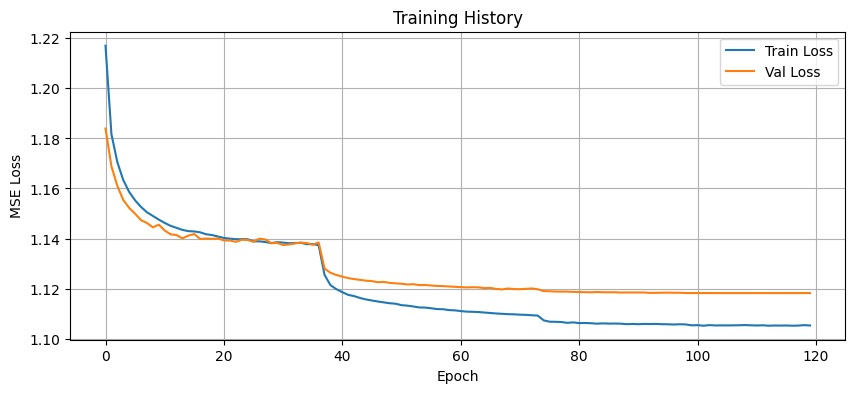

✓ Modèle sauvegardé: lstm_on_fractionnaly_differenciated_WN.pth


In [10]:
#Let's train the LSTM on the generated data using a ADAM optimizer and MSE loss
#parameters of training:
#for the optimizer: lr=0.01, scheduler (LROnPlateau): patience=5, eps=1e-6
#for the LSTM: 64 hidden size, 2 layers, dropout of 0.2

#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,
    hidden_size=64,
    dropout=0.2)

# Configuration (device already set in data preparation)
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6) #automatic learning rate adjustment

num_epochs = 120 #iteration number

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_on_fractionnaly_differenciated_WN.pth')

print("✓ Modèle sauvegardé: lstm_on_fractionnaly_differenciated_WN.pth")

The validation loss seems to have reached a plateau at around 50 iterations with a loss around 1.12. We can stop our training at 50 iterations.

#### Let's verify the long memory property in the LSTM trained

First, let's extract the last layer of our trained LSTM

In [11]:
#Loading the trained model
model.load_state_dict(torch.load('lstm_on_fractionnaly_differenciated_WN.pth')["model_state_dict"])
model.to(device)
model.eval()


hidden_states_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        lstm_out, (h_n, c_n) = model.lstm(X_batch)
        hidden_states_val.append(h_n[-1].cpu())

hidden_rep = torch.cat(hidden_states_val, dim=0).numpy()

print(f"Hidden representation shape: {hidden_rep.shape}")
print(f"Number of time steps in test: {hidden_rep.shape[0]}")
print(f"Hidden state dimension: {hidden_rep.shape[1]}")

Hidden representation shape: (13056, 64)
Number of time steps in test: 13056
Hidden state dimension: 64




## Theoretical Framework: VARFIMA Behavior in LSTMs

If an LSTM successfully captures long memory, it should behave like a **VARFIMA model**. Let's examine what this means:

### VARFIMA Model
A VARFIMA process is defined as:
$$\Psi(B) X_t = Z_t$$

where the inverse filter is:
$$\Psi(B) = (1-B)^d$$

and the inverse operation is:
$$X_t = \Psi(B)^{-1} Z_t = (1-B)^{-d} Z_t$$

### Test 1: Fractionally Differenced Input

Our genereated input is a **fractionally differenced white noise**:
$$\tilde{X}_t = (1-B)^d Z_t$$

If the LSTM has learned the VARFIMA structure, its hidden state should perform the inverse operation:
$$h_t = \Psi(\tilde{X}_t) = (1-B)^{-d} \tilde{X}_t = (1-B)^{-d} (1-B)^d Z_t = Z_t$$

**Expected result**: If the LSTM has long memory property, the hidden state $h_t$ should equal white noise $Z_t$, which has **$d = 0$**, meaning that the LSTM sucessfully captured and removed the long memory in the differenciated white noise.

#### Hypothesis Test

We test:
- **H0**: $d = 0$ (hidden states have no long memory, LSTM has long memory)
- **H1**: $d \neq 0$ (hidden states have long memory, LSTM does not have long memory)

The test uses the GSE statistics to estimate the long memory parameter $d$ from the hidden representation and returns a p-value.

In [12]:
# Test long memory on LSTM hidden states

hidden_rep_transposed = hidden_rep.T

tot_mem_hidden, std_var_hidden, p_val_hidden = compute_total_memory(
    hidden_rep_transposed)


print(f"TEST 1: LSTM trained on Fractionally Differenced White Noise")
print(f"  Total long memory: {tot_mem_hidden:.6f}")
print(f"  Std deviation: {np.sqrt(std_var_hidden):.6f}")
print(f"  p-value (H0: d=0): {p_val_hidden:.4e}")
print(f"\nConclusion:")
if p_val_hidden < 0.05:
    print(f"  ✗ H0 is rejected (p < 0.05): d ≠ 0")
    print(f"  → Hidden states still contains long memory --> LSTM has no long memory property")
else:
    print(f"   H0 is accepted (p ≥ 0.05): d ≈ 0")
    print(f" → Hidden states does not contain long memory anymore --> LSTM has long memory property")

TEST 1: LSTM trained on Fractionally Differenced White Noise
  Total long memory: -0.008825
  Std deviation: 0.062500
  p-value (H0: d=0): 5.5614e-01

Conclusion:
   H0 is accepted (p ≥ 0.05): d ≈ 0
 → Hidden states does not contain long memory anymore --> LSTM has long memory property


We ran the test on the last layer of our LSTM and the test gave a long memory statistic d = 0.0047 and a non significative p-value around 0.7

We can't reject the hypothesis of absence of long memory. The trained LSTM failed to adapt the behaviour of a VARFIMA. It means that it does not have long memory property.

## Test 2: Long memory transformation of white noise

### Generation of a White Noise

In [13]:
# Generate pure White Noise
np.random.seed(42)
k_wn = 200
T_wn = 2**16
WN_seq = torch.randn(k_wn, T_wn)  # Pure white noise: N(0,1)

print(f"\nGenerated White Noise:")
print(f"  Shape: {WN_seq.shape}")
print(f"  Mean: {WN_seq.mean():.6f} (should be ~0)")
print(f"  Std: {WN_seq.std():.6f} (should be ~1)")
print(f"  Min/Max: [{WN_seq.min():.4f}, {WN_seq.max():.4f}]")


Generated White Noise:
  Shape: torch.Size([200, 65536])
  Mean: -0.000262 (should be ~0)
  Std: 1.000111 (should be ~1)
  Min/Max: [-5.4476, 5.6275]


In [14]:
# Create supervised dataset with rolling window process on GPU
X_wn, y_wn = unfold_sequence_to_supervised_dataset(
    WN_seq, seq_length=256, forecast_horizon=1, device=device)
print(f"\nTest 2 dataset created on {device}")
print(f"  X memory: {X_wn.element_size() * X_wn.nelement() / 1e9:.2f} GB")
print(f"  y memory: {y_wn.element_size() * y_wn.nelement() / 1e9:.2f} GB")


#Train/test split dataset
full_dataset_wn = TensorDataset(X_wn, y_wn)
train_size_wn = int(0.8 * len(full_dataset_wn))
val_size_wn = len(full_dataset_wn) - train_size_wn

train_dataset_wn, val_dataset_wn = torch.utils.data.random_split(
    full_dataset_wn, [train_size_wn, val_size_wn]
)

train_loader_wn = DataLoader(train_dataset_wn, batch_size=32, shuffle=True)
val_loader_wn = DataLoader(val_dataset_wn, batch_size=32, shuffle=False)

print(f"\nDataset shapes:")
print(f"  X shape: {X_wn.shape}")
print(f"  y shape: {y_wn.shape}")
print(f"  Train samples: {len(train_dataset_wn)}")
print(f"  Val samples: {len(val_dataset_wn)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.45 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.98 GiB is free. Process 2770 has 12.76 GiB memory in use. Of the allocated memory 12.58 GiB is allocated by PyTorch, and 45.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#Let's train the LSTM on the training set using a ADAM optimizer and MSE loss
#parameters of training:
#for the optimizer: lr=0.01, scheduler (LROnPlateau): patience=5, eps=1e-6
#for the LSTM: 64 hidden size, 2 layers, dropout of 0.2

#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,
    hidden_size=64,
    dropout=0.2)

# Configuration (device already set in data preparation)
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6) #automatic learning rate adjustment

num_epochs = 100 #iteration number

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_wn:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader_wn)
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_wn:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader_wn)
    val_losses.append(val_loss)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_on_WN.pth')

print("✓ Modèle sauvegardé: lstm_on_WN.pth")

In [ ]:
#Loading the trained model
model.load_state_dict(torch.load('lstm_on_WN.pth')["model_state_dict"])
model.to(device)
model.eval()

#Extract hidden states on validation set
hidden_states_val = []
with torch.no_grad():
    for X_batch, _ in val_loader_wn:
        X_batch = X_batch.to(device)
        lstm_out, (h_n, c_n) = model.lstm(X_batch)
        hidden_states_val.append(h_n[-1].cpu())

hidden_rep = torch.cat(hidden_states_val, dim=0).numpy()

print(f"Hidden representation shape: {hidden_rep.shape}")
print(f"Number of time steps in test: {hidden_rep.shape[0]}")
print(f"Hidden state dimension: {hidden_rep.shape[1]}")

In [ ]:
# Test long memory on LSTM hidden states

hidden_rep_transposed = hidden_rep.T

tot_mem_hidden, std_var_hidden, p_val_hidden = compute_total_memory(
    hidden_rep_transposed)

print(f"TEST 2: Transformation of WN by LSTM")
print(f"  Total long memory: {tot_mem_hidden:.6f}")
print(f"  Std deviation: {np.sqrt(std_var_hidden):.6f}")
print(f"  p-value (H0: d=0): {p_val_hidden:.4e}")
print(f"\nConclusion:")
if p_val_hidden < 0.05:
    print(f"  ✗ H0 is rejected (p < 0.05): d ≠ 0")
    print(f"  →  LSTM has long memory property")
else:
    print(f"   H0 is accepted (p ≥ 0.05): d ≈ 0")
    print(f" →  LSTM has no long memory property")

### Monte Carlo Simulation

In [ ]:
#n=100 experiment for each test